## Data Treating

In [1]:
import os

# ===========================================
# 0. 环境准备
# pip install pandas scikit-learn matplotlib seaborn
# ===========================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib 不指定颜色让它自动配色即可
plt.rcParams["figure.dpi"] = 120
sns.set_style("whitegrid")

In [2]:
# ===========================================
# 1. 读数据 & 选特征
# ===========================================
csv_path = "Data/SPY_2020-07-01_2021-07-01_minute.csv"          # <== 换成你的文件
df = pd.read_csv(csv_path)

data_raw = df.copy()
data_raw = data_raw.set_index('timestamp')
# data_raw = data_raw.head(10000).set_index('timestamp')

In [3]:
data_raw.head(5)

,open,high,low,close,volume,dollar_volume,tick_count,trade_size_mean,trade_size_std,zero_return_count,price_direction_ratio,large_trade_count,large_trade_volume,vwap,large_trade_ratio,large_trade_volume_ratio
timestamp,,,,,,,,,,,,,,,,
2020-07-01 04:00:00-04:00,308.68,308.84,308.68,308.83,656.0,202545.01,16,41.000000,42.842347,9,0.250000,0,0.0,308.757637,0.0,0.0
2020-07-01 04:01:00-04:00,308.78,308.79,308.74,308.74,2594.0,800940.16,9,288.222222,219.928271,4,0.222222,0,0.0,308.766446,0.0,0.0
2020-07-01 04:02:00-04:00,308.77,308.84,308.77,308.84,807.0,249212.90,4,201.750000,235.213910,2,0.500000,0,0.0,308.814002,0.0,0.0
2020-07-01 04:03:00-04:00,308.82,308.84,308.82,308.84,89.0,27485.78,3,29.666667,9.073772,2,0.333333,0,0.0,308.828989,0.0,0.0
2020-07-01 04:04:00-04:00,308.84,308.90,308.84,308.90,501.0,154738.60,5,100.200000,86.024415,2,0.600000,0,0.0,308.859481,0.0,0.0


In [4]:
# ---------- 标签 & 前向对数收益 ----------

H   = 5          # 前瞻 5 bar
TAU = 0.01     # 1 bp 阈值（对数尺度近似同样大小）

# ★ 对数收益：ln(P_{t+H} / P_t)
fwd_ret_full = np.log(data_raw['close'].shift(-H) / data_raw['close'])

labels = np.select(
    [fwd_ret_full >  TAU,
     fwd_ret_full < -TAU],
    [ 1,               -1],            # Buy=1, Sell=-1
    default = 0
)

labels = pd.Series(labels, index=fwd_ret_full.index)\
           .where(fwd_ret_full.notna())

data_raw['action'] = labels
data_raw = data_raw.dropna(subset=['action'])

In [5]:
data_raw[data_raw['action'] != 0].size

2074

In [6]:
from ta.momentum import RSIIndicator
# 1. 定义要做 Min-Max 归一化的列
unbounded_features_cols = [
    'open', 'high', 'low', 'close',
    'volume', 'vwap', 'dollar_volume',
    'tick_count', 'trade_size_mean',
    'zero_return_count', 'large_trade_count',
    'large_trade_volume'
]

def compute_bounded_indicators(
    df: pd.DataFrame,
    unbounded_cols: list[str],
    rsi_period: int = 14
) -> pd.DataFrame:
    """
    对 df 中指定的“unbounded_cols”列表里的每一列, 计算 RSI 作为 bounded indicator 并添加新列。
    最后自动丢弃开头所有因 RSI 滚动窗口计算产生 NaN 的行，并对中间零星 NaN 做线性插值补全。

    参数
    ----------
    df : pd.DataFrame
        原始数据，至少应包含 unbounded_cols 中列。假设这些列本身不含 NaN。
    unbounded_cols : List[str]
        要对其计算 RSI(bounded indicator)的列名列表, 例如:
        ['open', 'high', 'low', 'close', 'volume', 'vwap', 'dollar_volume',
         'tick_count', 'trade_size_mean', 'zero_return_count',
         'large_trade_count', 'large_trade_volume']
    rsi_period : int, default 14
        RSI 计算窗口大小。RSI 的输出区间为 [0, 100]。

    返回
    ----------
    df_out : pd.DataFrame
        包含原始所有列 + 对每个 unbounded_cols 中列计算的 RSI 列（名为 "rsi(col)"），
        且开头自动删除所有 NaN 行，剩余部分的零星 NaN 已做线性插值补全。
    """

    data = df.copy()

    # 1. 为每个指定的 unbounded 列计算 RSI
    for col in unbounded_cols:
        # RSIIndicator 要求传入的是 pd.Series
        rsi_obj = RSIIndicator(close=data[col], window=rsi_period)
        data[f"rsi({col})"] = rsi_obj.rsi()

    # 2. 自动找出第一行“完全无 NaN”后，删除其之前所有行
    mask_any_na = data.isna().any(axis=1)
    if mask_any_na.all():
        # 如果极端情况所有行都含 NaN，则返回一个空 DataFrame（列名保持不变）
        return data.iloc[0:0]

    first_valid_idx = mask_any_na.idxmin()  # 第一个 False（表示无 NaN）的行标签
    data = data.loc[first_valid_idx:].copy()

    # 3. 对剩余行做线性插值，补全中间零星 NaN
    data = data.interpolate(method="linear", limit_direction="forward", axis=0)

    # （可选）如果尾部仍有 NaN，可根据需要改用 bfill：
    # data = data.fillna(method="bfill")

    return data

data_featured = compute_bounded_indicators(data_raw, unbounded_cols=unbounded_features_cols)
data_featured = data_featured.drop(columns=unbounded_features_cols)

In [7]:
data_featured.sample(5)

,trade_size_std,price_direction_ratio,large_trade_ratio,large_trade_volume_ratio,action,rsi(open),rsi(high),rsi(low),rsi(close),rsi(volume),rsi(vwap),rsi(dollar_volume),rsi(tick_count),rsi(trade_size_mean),rsi(zero_return_count),rsi(large_trade_count),rsi(large_trade_volume)
timestamp,,,,,,,,,,,,,,,,,
2020-09-08 08:13:00-04:00,266.584801,0.228571,0.034286,0.202665,0.0,42.600219,39.578178,28.834225,26.712631,57.185036,26.674339,57.154872,57.576279,49.958432,62.863889,57.117302,56.123526
2021-02-01 16:24:00-05:00,305.670147,0.137931,0.103448,0.461351,0.0,35.803136,35.559974,50.717309,35.462337,45.399558,49.264795,45.395793,43.756020,46.730021,43.574050,46.364531,46.403145
2021-05-13 18:41:00-04:00,17.511901,0.250000,0.000000,0.000000,0.0,44.463886,36.709723,45.641443,40.819676,48.108145,45.005517,48.108114,46.970955,48.128750,47.428612,46.634000,48.140477
2020-07-14 07:58:00-04:00,307.507867,0.222222,0.111111,0.330524,0.0,57.767158,57.000218,60.125428,58.499145,49.215633,57.884356,49.216993,48.603937,52.523195,48.775770,52.766854,51.404048
2021-03-11 13:45:00-05:00,174.264992,0.197516,0.032298,0.206319,0.0,42.373670,40.346125,51.122095,40.228737,48.896325,50.575104,48.899716,50.249902,48.056078,49.635049,52.019146,48.375199


In [8]:
# ===========================================
# 抓取y数据
# ===========================================

action_labels = data_featured["action"].values

In [9]:
action_labels

array([0., 0., 0., ..., 0., 0., 0.])

In [10]:
# ===========================================
# 2. 标准化 + PCA
# ===========================================
scaler = StandardScaler()
data_std  = scaler.fit_transform(data_featured)

# 先让 PCA 自己看看需要多少主成分能解释 90% 以上方差
pca_full = PCA().fit(data_std)
cum_var  = np.cumsum(pca_full.explained_variance_ratio_)
n_pc     = np.argmax(cum_var >= 0.90) + 1   # 第一满足阈值的位置

print(f"≥90% 方差用 {n_pc} 个主成分就够了")

# 这里示例用 2D 便于画图；实际建模可以用 n_pc
pca = PCA(n_components=n_pc, random_state=42)
data_pca = pca.fit_transform(data_std)

≥90% 方差用 7 个主成分就够了


In [11]:
data_pca.shape

(220143, 7)

In [12]:
# ===========================================
# 3-A. KMeans 聚类
#    —— 先用手肘法 / 轮廓系数粗调 k，再聚类
# ===========================================
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
from Utility import kmean_job

import os


scores = {}
futures = []

with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
    for k in range(2, 7):
        fut = executor.submit(kmean_job, k, data_pca)
        futures.append(fut)

    for fut in tqdm(as_completed(futures), total=len(futures), desc="计算各 k 的 silhouette_score"):
        k_val, score_val = fut.result()
        scores[k_val] = score_val

best_k = max(scores, key=scores.get)
print("最佳 k (silhouette max) =", best_k)
print("各 k 的分数详情：", scores)


kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
labels_km = kmeans.fit_predict(data_pca)

计算各 k 的 silhouette_score: 100%|██████████| 5/5 [08:27<00:00, 101.41s/it]


最佳 k (silhouette max) = 2
各 k 的分数详情： {5: np.float64(0.2075250552328456), 6: np.float64(0.20655570346559365), 4: np.float64(0.19972617465813414), 3: np.float64(0.23677801517498892), 2: np.float64(0.24804548612567057)}


In [13]:
# ===========================================
# 3-B. DBSCAN 聚类（示例参数 eps=0.5, min_samples=5）
#    —— 实战中可用 Nearest-Neighbor 距离图来调 eps
# ===========================================
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_db = dbscan.fit_predict(data_pca)

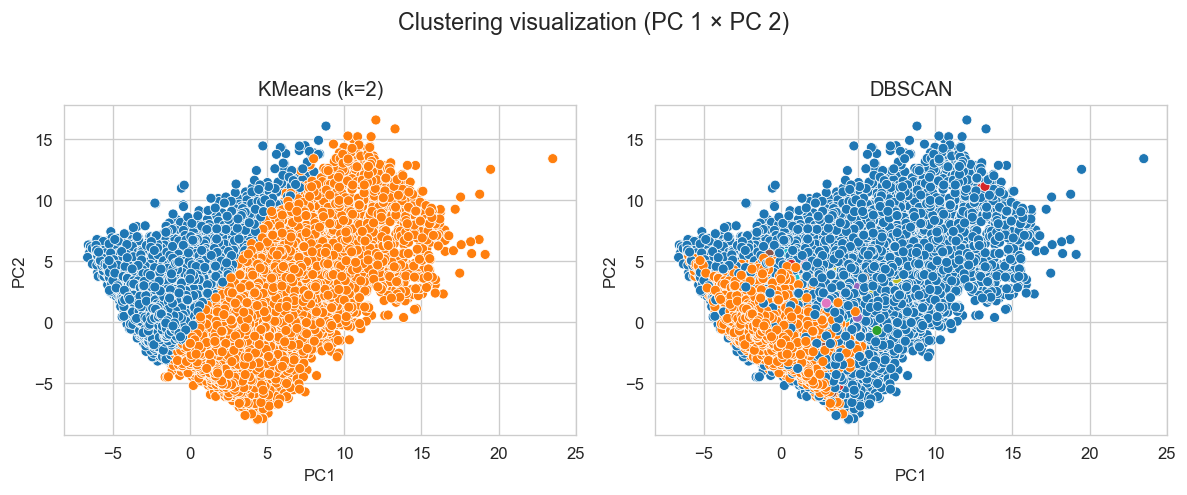

In [14]:
# ===========================================
# 4. 画图（课件风格：PC1 × PC2 散点，颜色=label）
# ===========================================
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# KMeans
sns.scatterplot(
    x=data_pca[:, 0], y=data_pca[:, 1],
    hue=labels_km.astype(str),      # 转成字符串让 seaborn 不误以为是连续变量
    palette="tab10", ax=axes[0], legend=False
)
axes[0].set_title(f"KMeans (k={best_k})")
axes[0].set_xlabel("PC1"); axes[0].set_ylabel("PC2")

# DBSCAN
sns.scatterplot(
    x=data_pca[:, 0], y=data_pca[:, 1],
    hue=labels_db.astype(str),
    palette="tab10", ax=axes[1], legend=False
)
axes[1].set_title("DBSCAN")
axes[1].set_xlabel("PC1"); axes[1].set_ylabel("PC2")

plt.suptitle("Clustering visualization (PC 1 × PC 2)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [15]:
feature_array = data_pca.copy()
target_array = action_labels.copy()
feature_array.shape, target_array.shape

((220143, 7), (220143,))

In [16]:
seq_len = 16

n_samples = len(action_labels) - seq_len

X = []
y = []

# —— 7. 滑动窗口遍历，填充 X 和 y —— #
for i in range(n_samples):
    # X[i] = features_array[i : i+seq_len]
    X.append(feature_array[i : i + seq_len, :])
    # y[i] = target_array[i+seq_len]
    y.append(target_array[i + seq_len])

X = np.array(X); y = np.array(y)


In [53]:
X.shape, y.shape

((220127, 16, 7), (220127,))

In [18]:
train_pct = 0.7
valid_pct = 0.15
test_pct = 0.15

total_len = X.shape[0]


train_len = int(train_pct * total_len)
valid_len = int(valid_pct * total_len)
test_len = int(test_pct * total_len)

X_train = X[:train_len]
X_valid = X[train_len:train_len+valid_len]
X_test = X[train_len+valid_len:]

y_train = y[:train_len]
y_valid = y[train_len:train_len+valid_len]
y_test = y[train_len+valid_len:]


print("X的尺寸", X_train.shape, X_valid.shape, X_test.shape)
print("y的尺寸", y_train.shape, y_valid.shape, y_test.shape)


X的尺寸 (154088, 16, 7) (33019, 16, 7) (33020, 16, 7)
y的尺寸 (154088,) (33019,) (33020,)


In [19]:
# 假设 X_train.shape == (154088, 16, 7)，y_train.shape == (154088,)
# 要把 X_train 从 (n_samples, seq_len, n_feats) 重塑成 (n_samples, seq_len * n_feats)
n_samples, seq_len, n_feats = X_train.shape

# 方法一：直接 reshape
X_train_flat = X_train.reshape(n_samples, seq_len * n_feats)  
# 同样对验证集和测试集也要做同样的 reshape
X_valid_flat = X_valid.reshape(X_valid.shape[0], seq_len * n_feats)
X_test_flat  = X_test.reshape(X_test.shape[0],  seq_len * n_feats)

In [20]:
print(X_train.shape)         # (154088, 16, 7)
X_train_flat = X_train.reshape(n_samples, seq_len * n_feats)
print(X_train.shape)         # 仍然是 (154088, 16, 7)
print(X_train_flat.shape)    # (154088, 112)

(154088, 16, 7)
(154088, 16, 7)
(154088, 112)


## Model Building - FROM LIAO ZIYU

#### 2d model

In [21]:
# 0 Prereqs – keep these in one cell
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.linear_model   import LogisticRegression
from sklearn.svm            import LinearSVC
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.ensemble       import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (accuracy_score, f1_score,
                             classification_report, confusion_matrix)

plt.rcParams['figure.dpi'] = 120
sns.set_style('whitegrid')

In [22]:
# 1 Pick up the arrays you already built

# !! run AFTER you executed your preprocessing block !!
# X_train_flat, X_valid_flat, X_test_flat, y_train, y_test already exist

# # optional: merge train+valid for more data
# X_tr   = np.vstack([X_train_flat, X_valid_flat])
# y_tr   = np.concatenate([y_train,  y_valid])

idx_all   = data_featured.index[seq_len:]  

idx_all   = data_featured.index[seq_len:]               # timeline after windowing
idx_test  = idx_all[len(y_train)+len(y_valid):]         # align with y_test

In [23]:
# 2 Model zoo (6 total)

sk_models = {
    "LogReg-Softmax": LogisticRegression(
        multi_class='multinomial', class_weight='balanced',
        max_iter=400, n_jobs=-1, C=1.0, solver='lbfgs'),

    "Linear-SVM":     LinearSVC(class_weight='balanced', C=1.0),

    "k-NN (k=15)":    KNeighborsClassifier(n_neighbors=15, weights='distance'),

    "Random Forest":  RandomForestClassifier(
        n_estimators=400, min_samples_leaf=25,
        n_jobs=-1, random_state=42),

    "Hist GBDT":      HistGradientBoostingClassifier(
        max_depth=4, learning_rate=0.05, max_iter=600,
        class_weight='balanced', random_state=42),

    "2-Layer MLP":    MLPClassifier(hidden_layer_sizes=(128, 64),
        activation='relu', batch_size=2**12, early_stopping=True,
        alpha=1e-4, random_state=42)
}


In [24]:
# 3 Fit → predict → collect metrics

metric_rows, cmaps = [], {}
for name, clf in sk_models.items():
    clf.fit(X_train_flat, y_train)
    y_pred = clf.predict(X_test_flat)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average='macro')
    metric_rows.append({"model": name, "accuracy": acc, "macro_F1": f1})

    cmaps[name] = confusion_matrix(y_test, y_pred,
                                   labels=[-1, 0, 1], normalize='true')

    print(f"\n{name}\n" + classification_report(y_test, y_pred, digits=3))

metric_df = pd.DataFrame(metric_rows).set_index("model").round(3)
display(metric_df)

/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



LogReg-Softmax
              precision    recall  f1-score   support

        -1.0      0.001     1.000     0.002         2
         0.0      1.000     0.895     0.944     33015
         1.0      0.001     0.333     0.001         3

    accuracy                          0.895     33020
   macro avg      0.334     0.743     0.316     33020
weighted avg      1.000     0.895     0.944     33020


Linear-SVM
              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000         2
         0.0      1.000     0.989     0.994     33015
         1.0      0.006     0.333     0.013         3

    accuracy                          0.988     33020
   macro avg      0.335     0.441     0.336     33020
weighted avg      1.000     0.988     0.994     33020


k-NN (k=15)
              precision    recall  f1-score   support

        -1.0      0.500     0.500     0.500         2
         0.0      1.000     1.000     1.000     33015
         1.0      1.000     0.333 

/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera


Random Forest
              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000         2
         0.0      1.000     1.000     1.000     33015
         1.0      0.000     0.000     0.000         3

    accuracy                          1.000     33020
   macro avg      0.333     0.333     0.333     33020
weighted avg      1.000     1.000     1.000     33020


Hist GBDT
              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000         2
         0.0      1.000     0.972     0.986     33015
         1.0      0.012     0.333     0.023         3

    accuracy                          0.972     33020
   macro avg      0.337     0.435     0.336     33020
weighted avg      1.000     0.972     0.986     33020


2-Layer MLP
              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000         2
         0.0      1.000     1.000     1.000     33015
         1.0      0.000     0.000   

/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ziwenchen/miniconda3/envs/BeatBuynHold/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

,accuracy,macro_F1
model,,
LogReg-Softmax,0.895,0.316
Linear-SVM,0.988,0.336
k-NN (k=15),1.000,0.667
Random Forest,1.000,0.333
Hist GBDT,0.972,0.336
2-Layer MLP,1.000,0.333


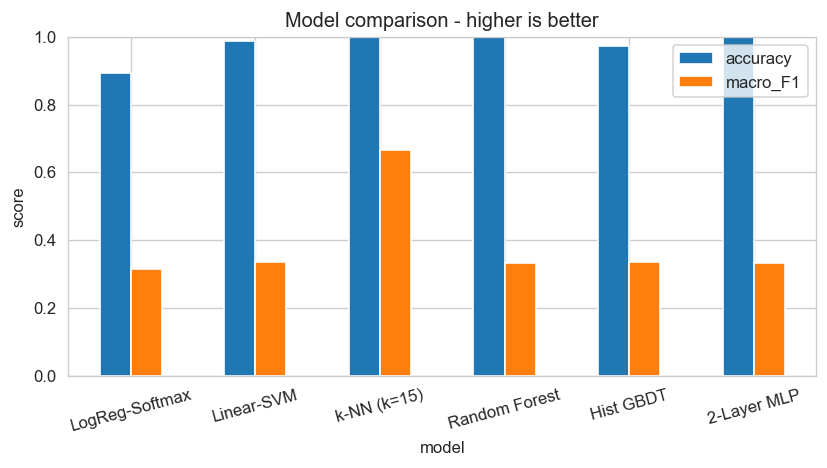

In [26]:
# 4 Visual summaries

# 4-A Accuracy vs. macro-F1
metric_df.plot(kind='bar', figsize=(7,4), rot=15, ylim=(0,1),
               title="Model comparison - higher is better")
plt.ylabel("score"); plt.tight_layout(); plt.show()

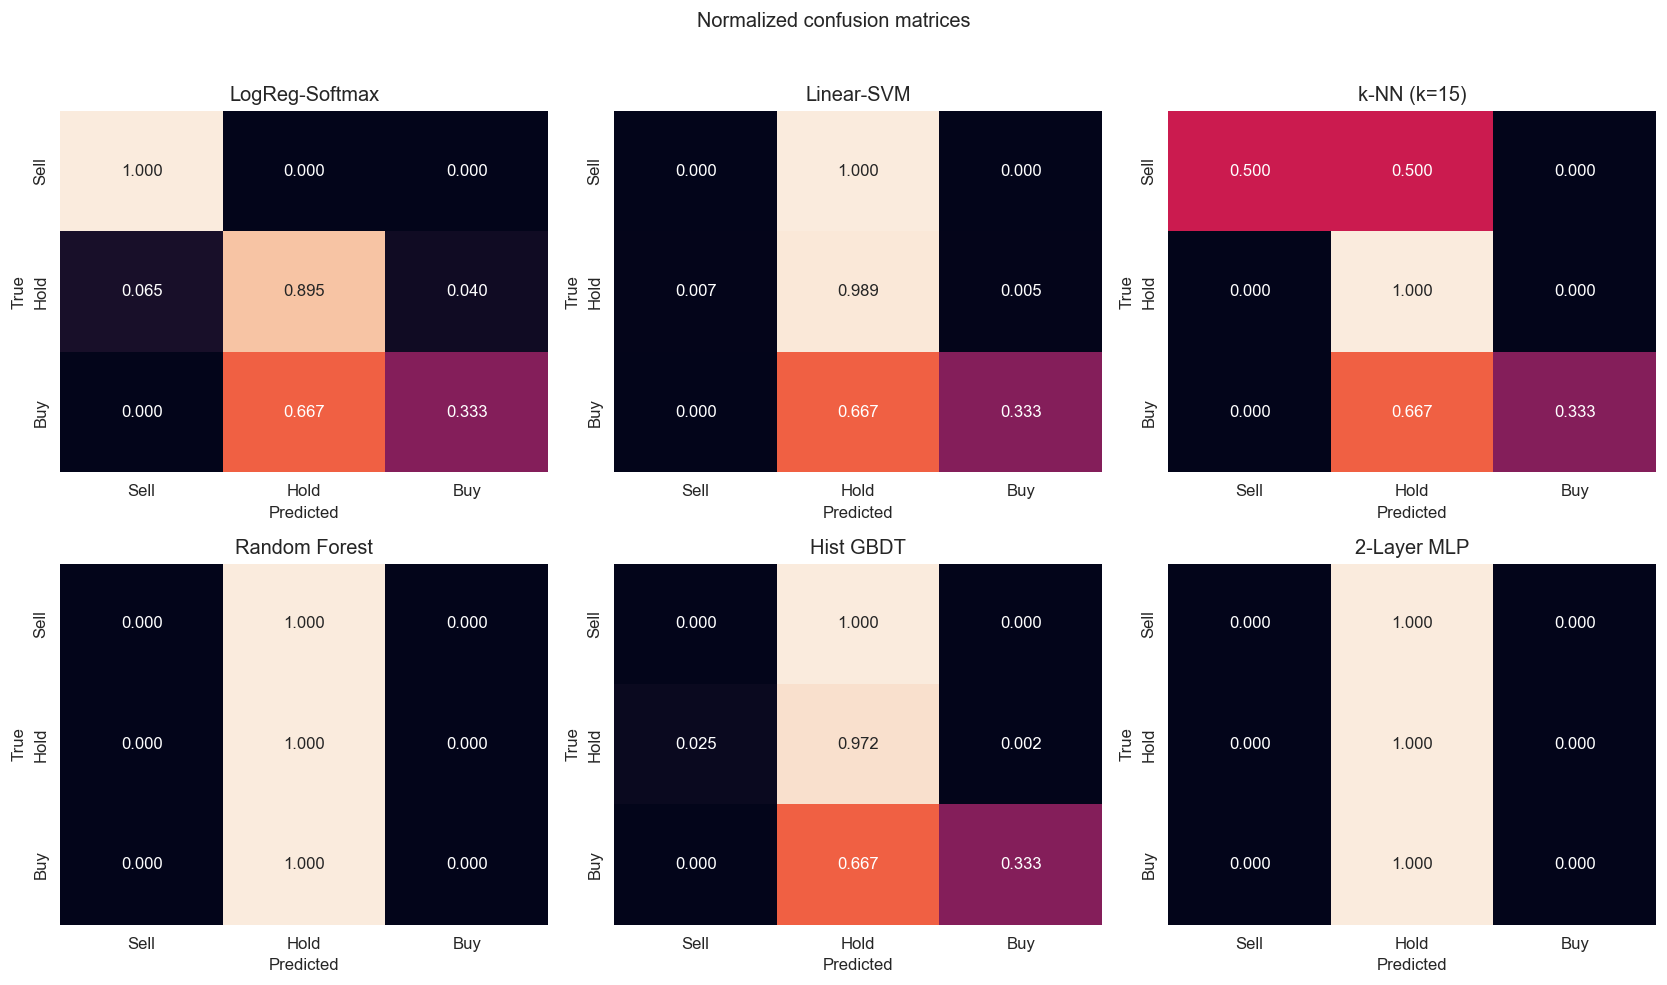

In [30]:
# 4-B Confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(14,8))
for ax, (name, cm) in zip(axes.ravel(), cmaps.items()):
    sns.heatmap(cm, annot=True, fmt=".3f", cbar=False,
                xticklabels=["Sell","Hold","Buy"],
                yticklabels=["Sell","Hold","Buy"],
                ax=ax,)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(name)
plt.suptitle("Normalized confusion matrices", y=1.02)
plt.tight_layout(); plt.show()

/var/folders/mh/pbgs4l0n1md9_5k62z5kmr980000gn/T/ipykernel_4127/2996498548.py:15: RuntimeWarning: invalid value encountered in scalar divide
  sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)   # 1-min bars? adapt if 5-min
/var/folders/mh/pbgs4l0n1md9_5k62z5kmr980000gn/T/ipykernel_4127/2996498548.py:15: RuntimeWarning: invalid value encountered in scalar divide
  sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)   # 1-min bars? adapt if 5-min


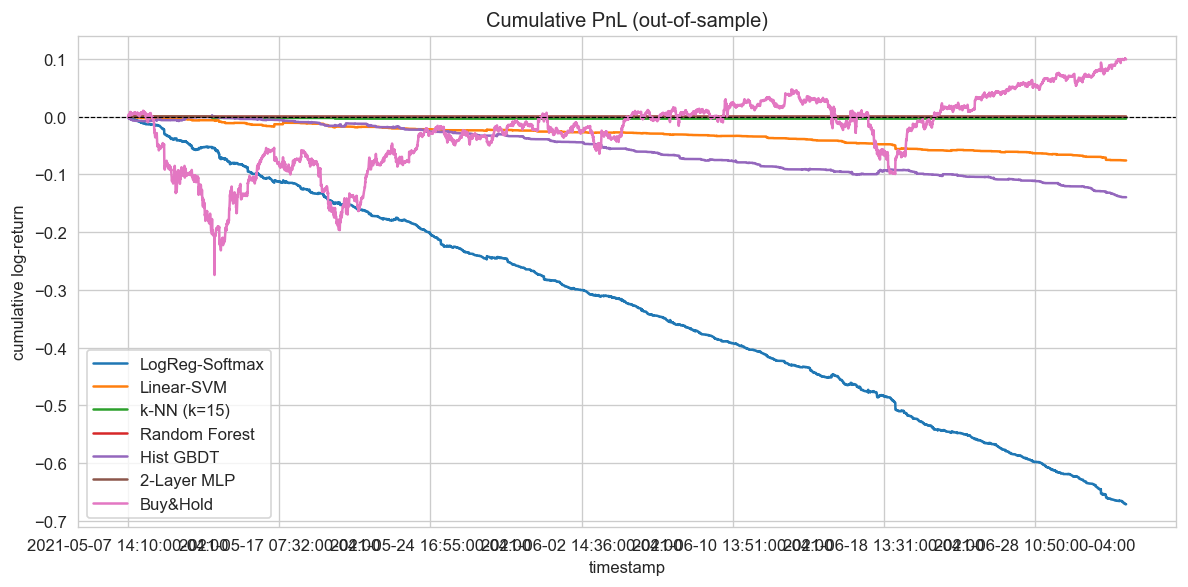

,Sharpe
LogReg-Softmax,-37.90
Linear-SVM,-12.48
k-NN (k=15),-2.54
Random Forest,NaN
Hist GBDT,-16.13
2-Layer MLP,NaN
Buy&Hold,1.21


In [83]:
# 5 Back-test – every model plus Buy & Hold
def backtest(pred, ret, fee_bp=1):
    gross = pred.shift(1) * ret           # enter next bar
    fee   = (pred.diff().abs() > 0).astype(int) * fee_bp/1e4
    return gross - fee

# realised forward log-return you already made
ret_test = fwd_ret_full.loc[idx_test]     # align to y_test timeline

pnl_curves, sharpes = {}, {}
for name, clf in sk_models.items():
    pred = pd.Series(clf.predict(X_test_flat), index=idx_test, name=name)
    pnl  = backtest(pred, ret_test)
    pnl_curves[name] = pnl.cumsum()
    sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)   # 1-min bars? adapt if 5-min

# --- Buy & Hold baseline ---
bh_pred = pd.Series(1, index=idx_test, name="Buy&Hold")
pnl_bh  = backtest(bh_pred, ret_test, fee_bp=0)             # no fee for hold
pnl_curves["Buy&Hold"] = pnl_bh.cumsum()
sharpes["Buy&Hold"]    = pnl_bh.mean()/pnl_bh.std()*np.sqrt(252*390)

# --- plot curves -----------------------------------------------------------
pd.DataFrame(pnl_curves).plot(figsize=(10,5))
plt.axhline(0, ls='--', lw=0.7, c='k')
plt.title("Cumulative PnL (out-of-sample)")
plt.ylabel("cumulative log-return")
plt.tight_layout()
plt.show()

# --- Sharpe table ----------------------------------------------------------
sharpe_tbl = pd.Series(sharpes).round(2).rename("Sharpe").to_frame()
display(sharpe_tbl)


#### 3d model

In [84]:
import numpy as np, pandas as pd, tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ❶ map {-1,0,1} → {0,1,2} for soft-max
label_map  = {-1:0, 0:1, 1:2}
inv_map    = {v:k for k,v in label_map.items()}

y_train_int = np.vectorize(label_map.get)(y_train)
y_valid_int = np.vectorize(label_map.get)(y_valid)
y_test_int  = np.vectorize(label_map.get)(y_test)

Model A — 1-D CNN

In [85]:
def make_cnn(seq_len=16, n_feats=7, n_classes=3):
    m = models.Sequential([
        layers.Input(shape=(seq_len, n_feats)),
        layers.Conv1D(64, 3, padding="causal", activation="relu"),
        layers.Conv1D(64, 3, padding="causal", activation="relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(32, activation="relu"),
        layers.Dense(n_classes, activation="softmax")
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
    return m

cnn = make_cnn()
hist = cnn.fit(X_train, y_train_int,
               epochs=15, batch_size=2048,
               validation_data=(X_valid, y_valid_int),
               callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
               verbose=2)


Epoch 1/15
76/76 - 2s - 23ms/step - accuracy: 0.9823 - loss: 0.1078 - val_accuracy: 0.9998 - val_loss: 0.0044
Epoch 2/15
76/76 - 1s - 18ms/step - accuracy: 0.9993 - loss: 0.0101 - val_accuracy: 0.9998 - val_loss: 0.0041
Epoch 3/15
76/76 - 1s - 17ms/step - accuracy: 0.9993 - loss: 0.0087 - val_accuracy: 0.9998 - val_loss: 0.0038
Epoch 4/15
76/76 - 1s - 17ms/step - accuracy: 0.9993 - loss: 0.0079 - val_accuracy: 0.9998 - val_loss: 0.0035
Epoch 5/15
76/76 - 1s - 18ms/step - accuracy: 0.9993 - loss: 0.0074 - val_accuracy: 0.9998 - val_loss: 0.0034
Epoch 6/15
76/76 - 1s - 18ms/step - accuracy: 0.9993 - loss: 0.0072 - val_accuracy: 0.9998 - val_loss: 0.0033
Epoch 7/15
76/76 - 1s - 18ms/step - accuracy: 0.9993 - loss: 0.0071 - val_accuracy: 0.9998 - val_loss: 0.0033
Epoch 8/15
76/76 - 1s - 18ms/step - accuracy: 0.9993 - loss: 0.0070 - val_accuracy: 0.9998 - val_loss: 0.0033
Epoch 9/15
76/76 - 1s - 18ms/step - accuracy: 0.9993 - loss: 0.0069 - val_accuracy: 0.9998 - val_loss: 0.0033
Epoch 10/1

Model B — GRU (or LSTM)

In [86]:
def make_gru(seq_len=16, n_feats=7, n_classes=3):
    m = models.Sequential([
        layers.Input(shape=(seq_len, n_feats)),
        layers.GRU(64, return_sequences=False),
        layers.Dense(32, activation="relu"),
        layers.Dense(n_classes, activation="softmax")
    ])
    m.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
    return m

gru = make_gru()
hist_g = gru.fit(X_train, y_train_int,
                 epochs=15, batch_size=2048,
                 validation_data=(X_valid, y_valid_int),
                 callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
                 verbose=2)


Epoch 1/15
76/76 - 4s - 56ms/step - accuracy: 0.9917 - loss: 0.1905 - val_accuracy: 0.9998 - val_loss: 0.0026
Epoch 2/15
76/76 - 4s - 49ms/step - accuracy: 0.9993 - loss: 0.0051 - val_accuracy: 0.9998 - val_loss: 0.0023
Epoch 3/15
76/76 - 4s - 48ms/step - accuracy: 0.9993 - loss: 0.0045 - val_accuracy: 0.9998 - val_loss: 0.0022
Epoch 4/15
76/76 - 4s - 49ms/step - accuracy: 0.9993 - loss: 0.0043 - val_accuracy: 0.9998 - val_loss: 0.0021
Epoch 5/15
76/76 - 4s - 48ms/step - accuracy: 0.9993 - loss: 0.0042 - val_accuracy: 0.9998 - val_loss: 0.0021
Epoch 6/15
76/76 - 4s - 47ms/step - accuracy: 0.9993 - loss: 0.0041 - val_accuracy: 0.9997 - val_loss: 0.0022
Epoch 7/15
76/76 - 4s - 48ms/step - accuracy: 0.9994 - loss: 0.0040 - val_accuracy: 0.9997 - val_loss: 0.0021
Epoch 8/15
76/76 - 4s - 48ms/step - accuracy: 0.9994 - loss: 0.0039 - val_accuracy: 0.9998 - val_loss: 0.0021
Epoch 9/15
76/76 - 4s - 48ms/step - accuracy: 0.9994 - loss: 0.0039 - val_accuracy: 0.9998 - val_loss: 0.0020
Epoch 10/1

In [87]:
# Convert predictions back to {-1, 0, 1}
def keras_predict_to_series(model, X, idx):
    probs   = model.predict(X, verbose=0)
    y_hat_i = probs.argmax(axis=1)           # {0,1,2}
    y_hat   = np.vectorize(inv_map.get)(y_hat_i)
    return pd.Series(y_hat, index=idx)

pred_cnn = keras_predict_to_series(cnn, X_test,  idx_test)
pred_gru = keras_predict_to_series(gru, X_test,  idx_test)


In [88]:
# Evaluation block (reuse everything)
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# --- helper to append ------------------------------------------------------
def eval_and_store(name, pred_series):
    y_pred = pred_series.values
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average='macro')

    metric_df.loc[name] = [acc, f1]          # add new row
    cmaps[name] = confusion_matrix(y_test, y_pred,
                                   labels=[-1,0,1], normalize='true')

    print(f"\n{name}\n" + classification_report(y_test, y_pred, digits=3))

    pnl = backtest(pred_series, fwd_ret_full.loc[pred_series.index])
    pnl_curves[name] = pnl.cumsum()
    sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)

# --- evaluate the two deep models -----------------------------------------
eval_and_store("CNN-1d", pred_cnn)
eval_and_store("GRU",    pred_gru)


CNN-1d
              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000         2
         0.0      1.000     1.000     1.000     33015
         1.0      0.000     0.000     0.000         3

    accuracy                          1.000     33020
   macro avg      0.333     0.333     0.333     33020
weighted avg      1.000     1.000     1.000     33020


GRU
              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000         2
         0.0      1.000     1.000     1.000     33015
         1.0      0.000     0.000     0.000         3

    accuracy                          1.000     33020
   macro avg      0.333     0.333     0.333     33020
weighted avg      1.000     1.000     1.000     33020



/opt/anaconda3/envs/cfrm421/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/cfrm421/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/cfrm421/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [89]:
metric_df.sort_values("macro_F1", ascending=False, inplace=True)
display(metric_df.round(3))          # updated table

# bar-plot, confusion-matrix grid, PnL curve, Sharpe table:
#   (reuse the same code blocks as before)

,accuracy,macro_F1
model,,
k-NN (k=15),1.000,0.667
Linear-SVM,0.988,0.336
Hist GBDT,0.972,0.336
CNN-1d,1.000,0.333
GRU,1.000,0.333
Random Forest,1.000,0.333
2-Layer MLP,1.000,0.333
LogReg-Softmax,0.895,0.316


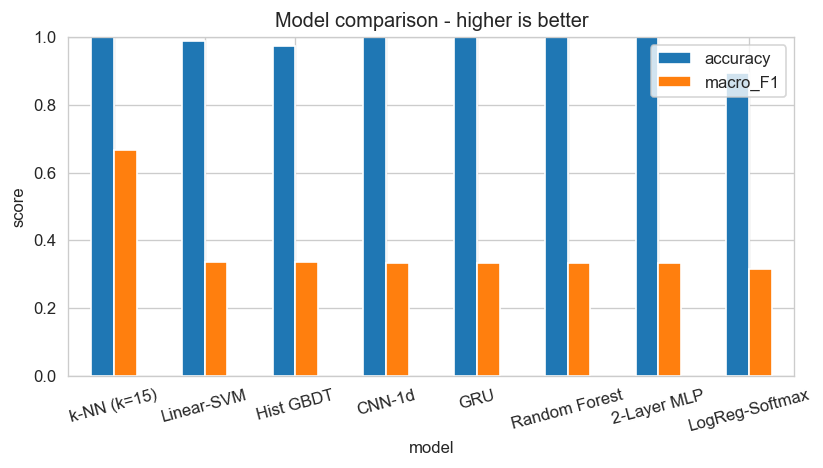

In [90]:
metric_df.plot(kind='bar', figsize=(7,4), rot=15, ylim=(0,1),
               title="Model comparison - higher is better")
plt.ylabel("score"); plt.tight_layout(); plt.show()

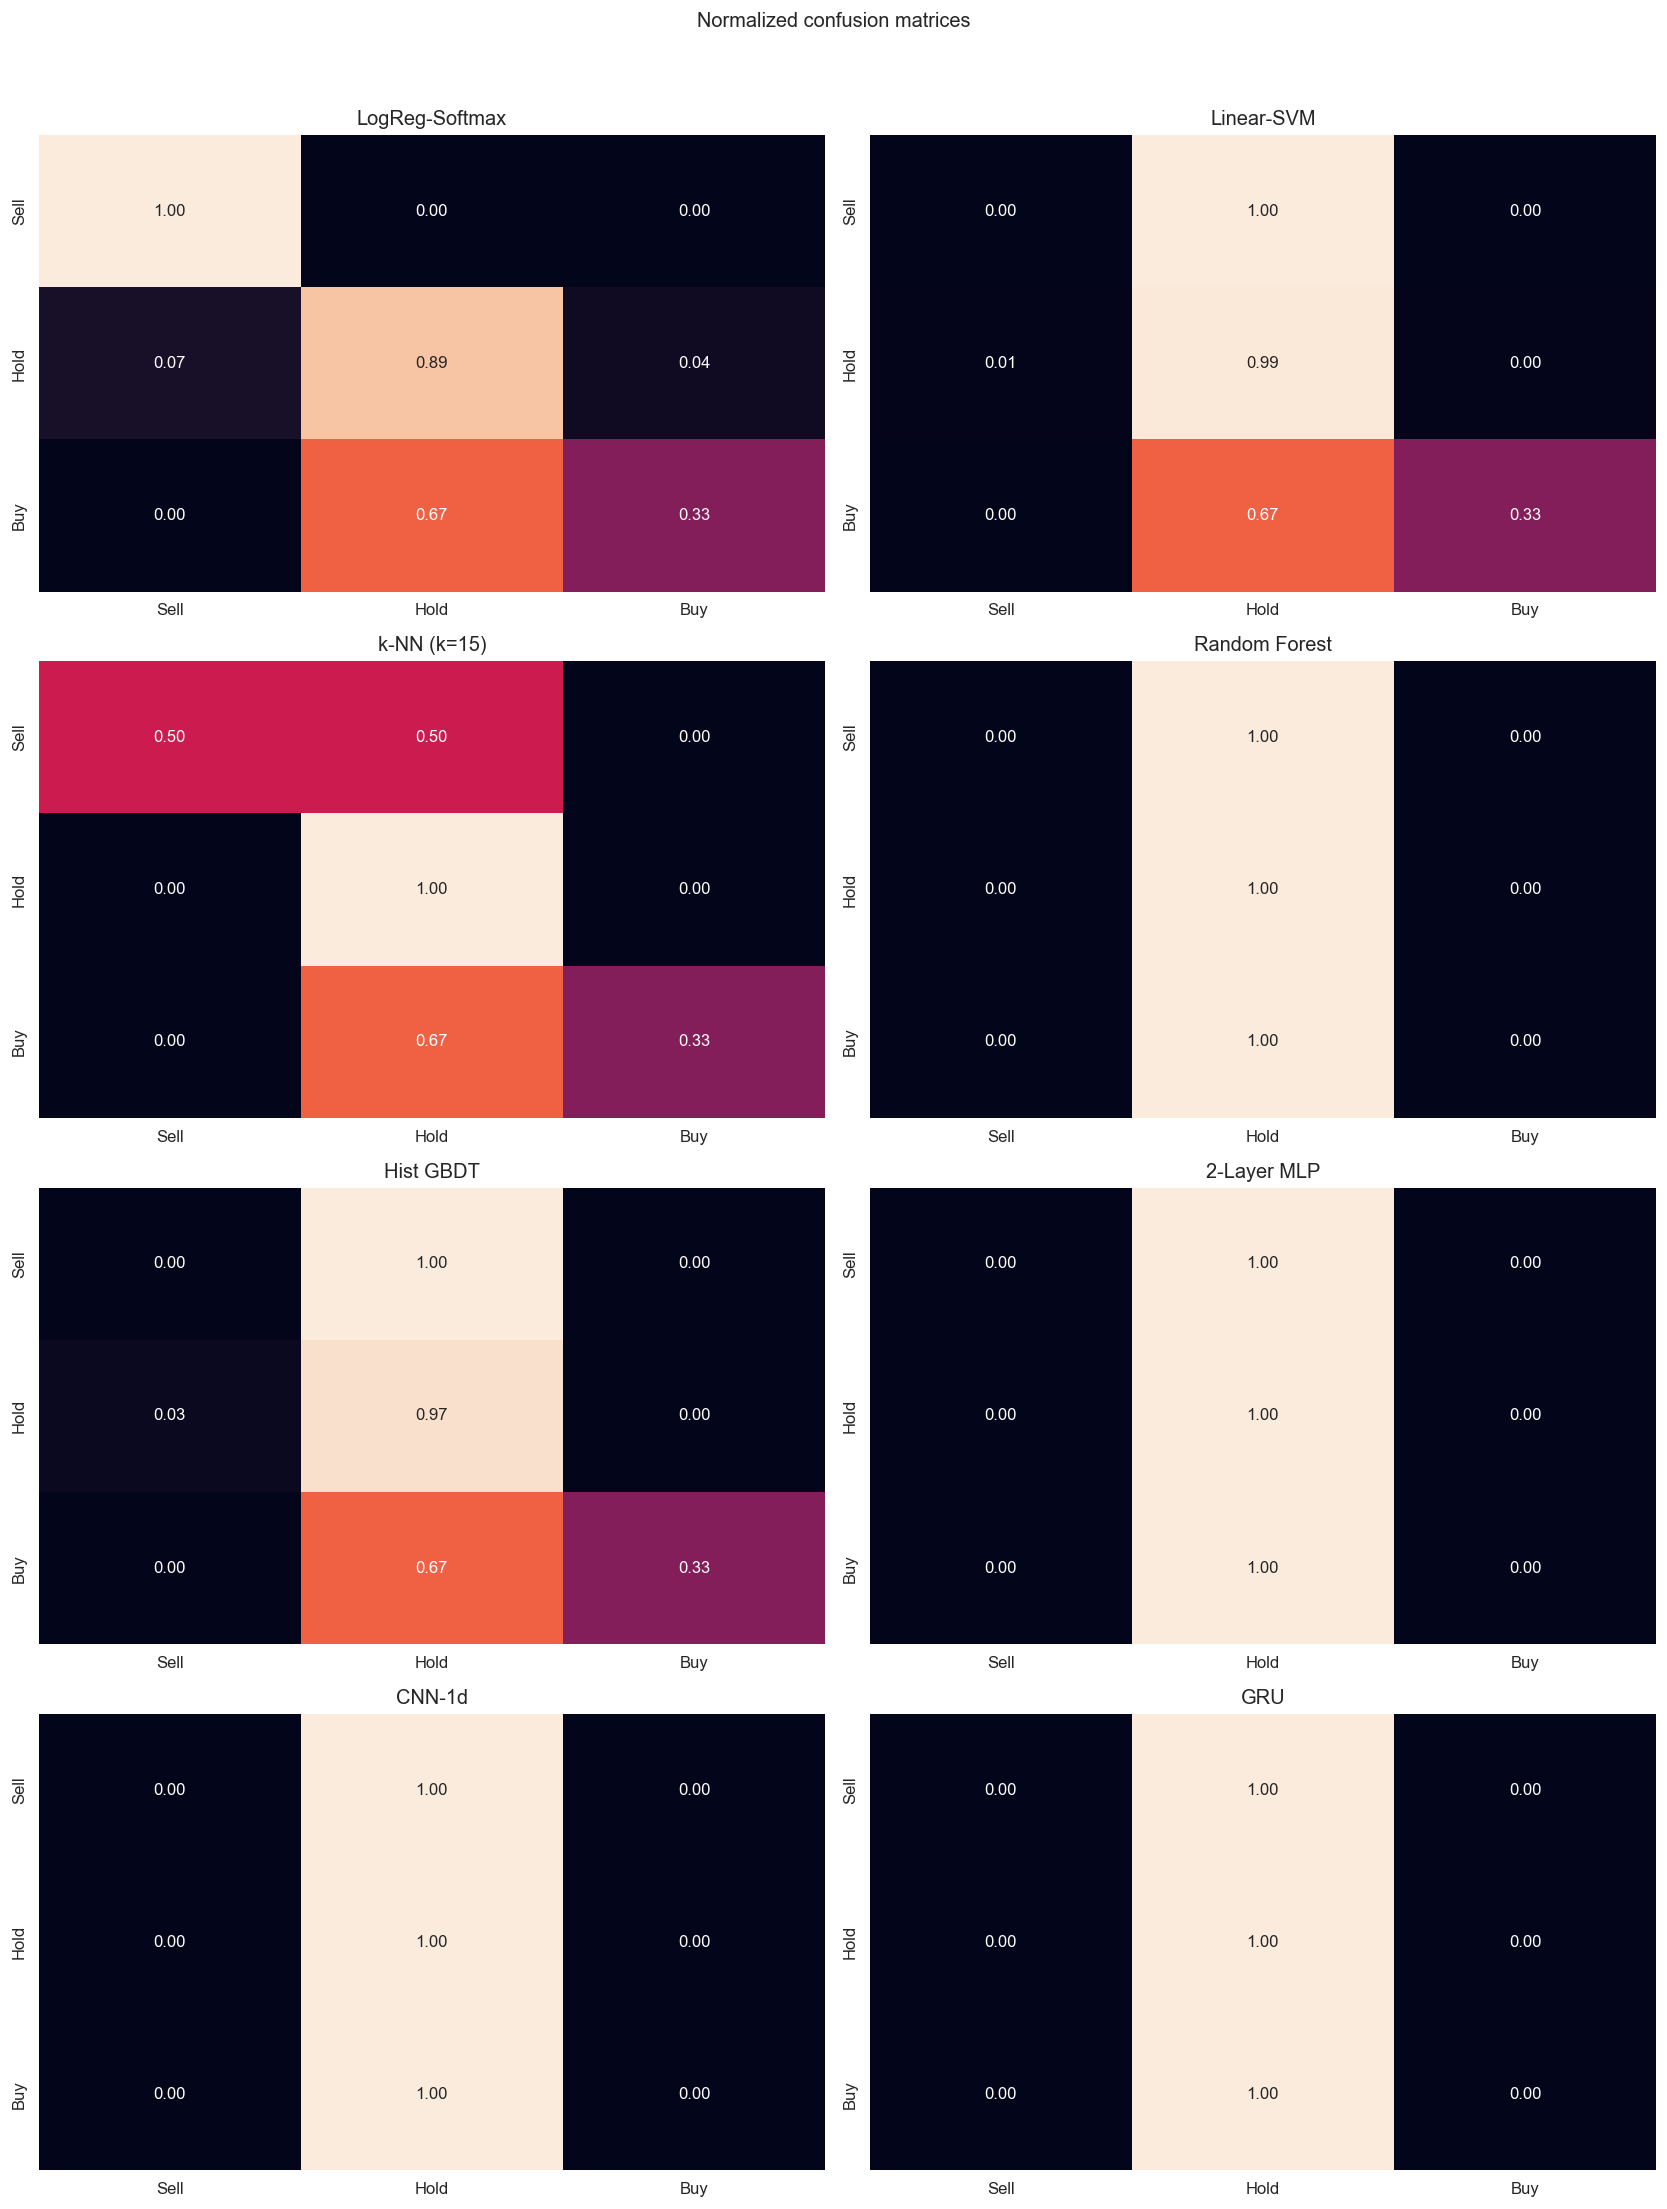

In [91]:
fig, axes = plt.subplots(4, 2, figsize=(14,18))
for ax, (name, cm) in zip(axes.ravel(), cmaps.items()):
    sns.heatmap(cm, annot=True, fmt=".2f", cbar=False,
                xticklabels=["Sell","Hold","Buy"],
                yticklabels=["Sell","Hold","Buy"], ax=ax)
    ax.set_title(name)
plt.suptitle("Normalized confusion matrices", y=1.02)
plt.tight_layout(); plt.show()

/var/folders/mh/pbgs4l0n1md9_5k62z5kmr980000gn/T/ipykernel_4127/4167790060.py:12: RuntimeWarning: invalid value encountered in scalar divide
  sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)
/var/folders/mh/pbgs4l0n1md9_5k62z5kmr980000gn/T/ipykernel_4127/4167790060.py:12: RuntimeWarning: invalid value encountered in scalar divide
  sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)
/var/folders/mh/pbgs4l0n1md9_5k62z5kmr980000gn/T/ipykernel_4127/4167790060.py:18: RuntimeWarning: invalid value encountered in scalar divide
  sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)
/var/folders/mh/pbgs4l0n1md9_5k62z5kmr980000gn/T/ipykernel_4127/4167790060.py:18: RuntimeWarning: invalid value encountered in scalar divide
  sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)


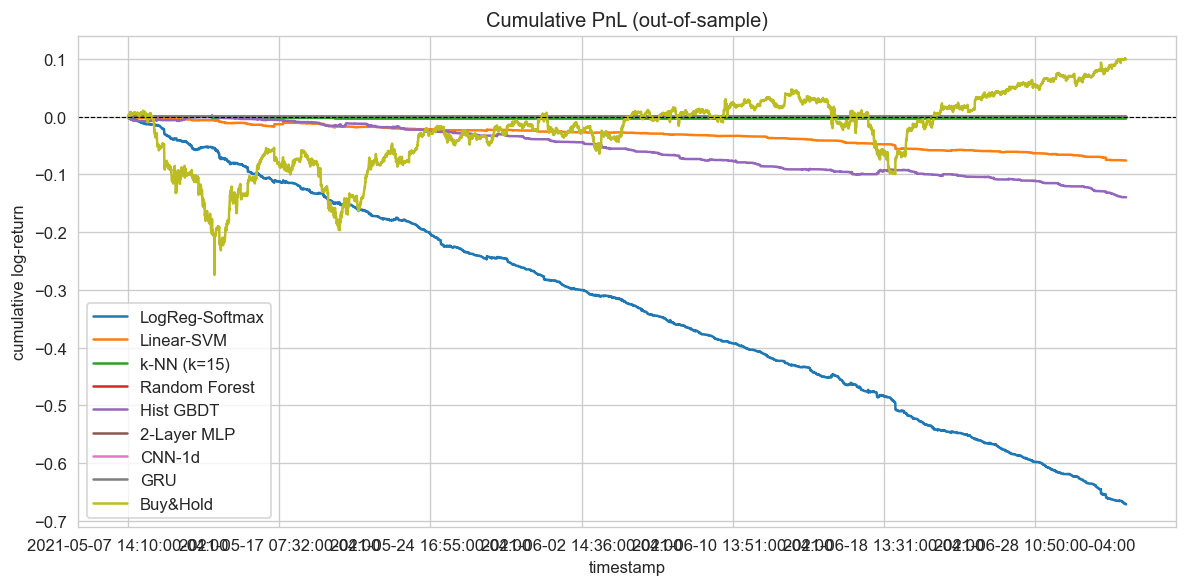

,Sharpe
LogReg-Softmax,-37.90
Linear-SVM,-12.48
k-NN (k=15),-2.54
Random Forest,NaN
Hist GBDT,-16.13
2-Layer MLP,NaN
CNN-1d,NaN
GRU,NaN
Buy&Hold,1.21


In [92]:
# realised forward log-return you already made
ret_test = fwd_ret_full.loc[idx_test]     # align to y_test timeline

# ---------- 回测 ----------
pnl_curves, sharpes = {}, {}

# 2-D scikit-learn 模型
for name, clf in sk_models.items():
    pred = pd.Series(clf.predict(X_test_flat), index=idx_test, name=name)
    pnl  = backtest(pred, ret_test)
    pnl_curves[name] = pnl.cumsum()
    sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)

# 3-D 深度模型
for name, pred in [("CNN-1d", pred_cnn), ("GRU", pred_gru)]:
    pnl  = backtest(pred, ret_test)
    pnl_curves[name] = pnl.cumsum()
    sharpes[name] = pnl.mean()/pnl.std()*np.sqrt(252*390)

# --- Buy & Hold baseline ---
bh_pred = pd.Series(1, index=idx_test, name="Buy&Hold")
pnl_bh  = backtest(bh_pred, ret_test, fee_bp=0)             # no fee for hold
pnl_curves["Buy&Hold"] = pnl_bh.cumsum()
sharpes["Buy&Hold"]    = pnl_bh.mean()/pnl_bh.std()*np.sqrt(252*390)

# --- plot curves -----------------------------------------------------------
pd.DataFrame(pnl_curves).plot(figsize=(10,5))
plt.axhline(0, ls='--', lw=0.7, c='k')
plt.title("Cumulative PnL (out-of-sample)")
plt.ylabel("cumulative log-return")
plt.tight_layout()
plt.show()

# --- Sharpe table ----------------------------------------------------------
sharpe_tbl = pd.Series(sharpes).round(2).rename("Sharpe").to_frame()
display(sharpe_tbl)


## Model Building - FROM WUTONG & WANG CHENXU

#### Ridge Classifier

In [ ]:
from sklearn.linear_model import RidgeClassifier
ridge = RidgeClassifier()
ridge.fit(X_train_flat, y_train)
ridge_val_pred = ridge.predict(X_valid_flat)
ridge_test_pred = ridge.predict(X_test_flat)

In [ ]:
accuracy = ridge.score(X_valid_flat, y_valid)
accuracy2 = ridge.score(X_test_flat, y_test)
print("Validation Accuracy:", accuracy)
print("Test Accuracy", accuracy2)

Validation Accuracy: 0.9997577152548532
Test Accuracy 0.9998485766202302


#### SVC

In [36]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm_clf_lsvc = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(loss="hinge", random_state=42))
    ])
param_grid = {
    "linear_svc__C": [10**(-k) for k in range(10)]
}
grid = GridSearchCV(
    estimator  = svm_clf_lsvc,
    param_grid = param_grid,
    cv         = 3,
    scoring    = "accuracy",
    n_jobs     = -1,
    verbose    = 1
)
grid.fit(X_train_flat, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

In [ ]:
best_C     = grid.best_params_["linear_svc__C"]
best_score = grid.best_score_

print(f"Best C: {best_C}")
print(f"Mean CV accuracy: {best_score:.4%}")

Best C: 1
Mean CV accuracy: 99.9332%


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform
from sklearn.svm import SVC

rbf_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", max_iter=50000, random_state=42))
])

param_dist = {
    "svc__C":       uniform(loc=1.0, scale=9.0),      # draws in [1,10)
    "svc__gamma":   loguniform(1e-4, 1e-1)            # draws from 1e-4 to 1e-1, PDF ∝1/x
}

search = RandomizedSearchCV(
    estimator    = rbf_svm,
    param_distributions = param_dist,
    n_iter       = 10,
    cv           = 3,
    scoring      = "accuracy",
    random_state = 42,
    n_jobs       = 1,
    verbose      = 1
)

search.fit(X_train_flat, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
best_C     = search.best_params_["svc__C"]
best_gamma = search.best_params_["svc__gamma"]
best_acc   = search.best_score_

print(f"Best C:     {best_C:.4g}")
print(f"Best gamma: {best_gamma:.4g}")
print(f"Mean CV accuracy: {best_acc:.2%}")

#### Random Forest

fitting a random forest to predict the 1-step ahead value of `log_volume`. The random forest include the argument `random_state=42`. Use 3-fold time series CV split to tune the hyperparameters `n_estimators` taking the values  200, 400, 600, and the cost-complexity pruning parameter $\alpha$ taking the values $10^{-k}$, $k=1,3,5,7$. When tuning hyperparameters on the validation sets, fit the model only on a random 10% sample of the instances of the training set on the same CV fold to reduce computational time.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def rf_model(X_train, y_train, X_test, y_test,
                  valid_or_test, ccp_alphas_list, n_estimators_list, optimal_par=None):

    rf_rmse = []
    param_combinations = []

    if valid_or_test == "valid":
        for alpha in ccp_alphas_list:
            for n_estimators in n_estimators_list:
                model_rf = RandomForestRegressor(
                    random_state=42,
                    ccp_alpha=alpha,
                    n_estimators=n_estimators,
                    n_jobs=-1
                )
                model_rf.fit(X_train, y_train.ravel())
                y_val_rf = model_rf.predict(X_test)
                rmse = np.sqrt(mean_squared_error(y_test, y_val_rf))
                rf_rmse.append(rmse)
                param_combinations.append((alpha, n_estimators))

        rf_rmse = np.array(rf_rmse)
        min_rmse_idx = np.argmin(rf_rmse)
        optimal_params = param_combinations[min_rmse_idx]
        return rf_rmse, optimal_params

    elif valid_or_test == "test":
        model_rf = RandomForestRegressor(
            random_state=42,
            ccp_alpha=optimal_par[0],
            n_estimators=optimal_par[1],
            n_jobs=-1
        )
        model_rf.fit(X_train, y_train.ravel())
        y_test_rf = model_rf.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_test_rf))

        plt.plot(y_test_rf, label="Prediction")
        plt.plot(y_test, label="True")
        plt.title("Random Forest: Prediction vs True")
        plt.legend()
        plt.tight_layout()
        plt.show()

        return rmse, y_test_rf, model_rf

In [ ]:
# 重新定义参数组合
n_estimators_list = [200, 400, 600]
ccp_alphas_list = [10**(-k) for k in [1, 3, 5, 7]]

# 手动划分验证集（若尚未划分）
# 假设 X_train, X_val, y_train, y_val 已经存在

# 调参（只需要一次验证）
rf_rmse, optimal_params = rf_model(
    X_train, y_train, X_valid, y_valid,
    valid_or_test="valid",
    ccp_alphas_list=ccp_alphas_list,
    n_estimators_list=n_estimators_list
)

# 打印每组超参数对应的 RMSE
ind = 0
for alpha in ccp_alphas_list:
    for n_estimators in n_estimators_list:
        print(f"(alpha, n_estimators): ({alpha}, {n_estimators})")
        print(f"  RMSE: {rf_rmse[ind]:.6f}")
        ind += 1

# 打印最优结果
print("✅ Optimal parameters:", optimal_params)
print("✅ Minimum RMSE:", min(rf_rmse))


#### MLP

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

def build_and_train_mlp_classifier(X_train, y_train, X_val, y_val, X_test, y_test,
                                    hidden_units=64, dropout_rate=0.2, epochs=100, batch_size=32):

    # 确保标签为整数类型（适用于 sparse_categorical_crossentropy）
    y_train = y_train.astype(int)
    y_val = y_val.astype(int)
    y_test = y_test.astype(int)

    # 构建模型
    model = Sequential([
        Dense(hidden_units, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(dropout_rate),
        Dense(hidden_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(3, activation='softmax')
    ])

    # 编译模型
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # 早停
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # 训练模型
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    # 测试集预测
    y_pred_prob = model.predict(X_test)
    y_pred = y_pred_prob.argmax(axis=1)

    # 打印分类报告
    print("✅ MLP Test Classification Report:")
    print(classification_report(y_test, y_pred))

    return model, history, y_pred



In [ ]:
model, history, y_pred = build_and_train_mlp_classifier(X_train, y_train, X_valid, y_valid, X_test, y_test)